In [1]:
#We stablish conection with google drive (just in case you are working with Google Colab)
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd "/content/drive/My Drive/Colab_Notebooks/Data_Science/7_LSTM"

/content/drive/My Drive/Colab_Notebooks/Data_Science/7_LSTM


# Install and Import libraries

In [3]:
!pip install tensorflow

In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils
from keras.callbacks import CSVLogger
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [5]:
np.random.seed(2)
utils.set_random_seed(2)

# Import datasets

Datasets were obtained from [Nasdaq webpage](https://www.nasdaq.com/market-activity/quotes/historical)

In [6]:
aapl = pd.read_csv('./data/aapl.csv')
amzn = pd.read_csv('./data/amzn.csv')
msft = pd.read_csv('./data/msft.csv')
tsla = pd.read_csv('./data/tsla.csv')

In [ ]:
aapl

,Date,Close/Last,Volume,Open,High,Low
0,01/05/2024,$181.18,62379660,$181.99,$182.76,$180.17
1,01/04/2024,$181.91,71983570,$182.15,$183.0872,$180.88
2,01/03/2024,$184.25,58414460,$184.22,$185.88,$183.43
3,01/02/2024,$185.64,82488670,$187.15,$188.44,$183.885
4,12/29/2023,$192.53,42672150,$193.90,$194.40,$191.725
...,...,...,...,...,...,...
2511,01/14/2014,$19.5139,332329907,$19.2222,$19.5261,$19.2022
2512,01/13/2014,$19.1332,378449529,$18.9254,$19.375,$18.9243
2513,01/10/2014,$19.0336,304941998,$19.2797,$19.3143,$18.9682
2514,01/09/2014,$19.1614,279051080,$19.5286,$19.5307,$19.1197


# Preproccessing datasets

In [7]:
# Get the date from each dataset
aapl_date = pd.to_datetime(aapl['Date'])
amzn_date = pd.to_datetime(amzn['Date'])
msft_date = pd.to_datetime(msft['Date'])
tsla_date = pd.to_datetime(tsla['Date'])

In [8]:
# extract the column names. It is the same for every database
cols = list(aapl)[1:6]
print(cols)

['Close/Last', 'Volume', 'Open', 'High', 'Low']


In [9]:
c_m = ['Close/Last', 'Open','High','Low']
for i in c_m:
  aapl[i] = aapl[i].apply(lambda x: str(x).strip('$'))
  amzn[i] = amzn[i].apply(lambda x: str(x).strip('$'))
  msft[i] = msft[i].apply(lambda x: str(x).strip('$'))
  tsla[i] = tsla[i].apply(lambda x: str(x).strip('$'))


In [10]:
aapl_ds_ws = aapl[cols].astype(float)
amzn_ds_ws = amzn[cols].astype(float)
msft_ds_ws = msft[cols].astype(float)
tsla_ds_ws = tsla[cols].astype(float)
aapl_ds_ws.dtypes

Close/Last    float64
Volume        float64
Open          float64
High          float64
Low           float64
dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

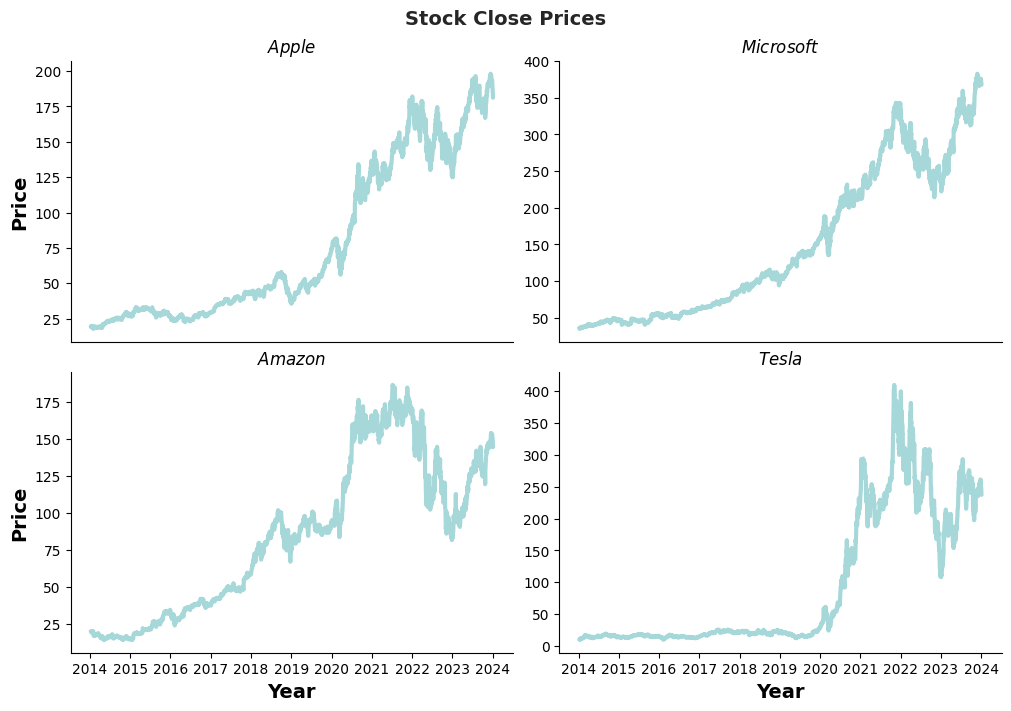

In [11]:
plt.rcdefaults()
fig, ax = plt.subplots(2,2, layout='constrained', figsize=(10,7))

val_col = '#A6D8DA'

sns.set_style("ticks")
b = sns.lineplot(x=aapl_date, y=aapl_ds_ws['Close/Last'], color=val_col, label='True', legend=False, linewidth=3, ax=ax[0, 0])
b.set_ylabel("Price", fontsize=14, fontweight="bold")
b.get_xaxis().set_visible(False)


d = sns.lineplot(x=amzn_date, y=amzn_ds_ws['Close/Last'], color=val_col, label='True', legend=False, linewidth=3, ax=ax[1, 0])
d.set_ylabel("Price", fontsize=14, fontweight="bold")
d.set_xlabel("Year", fontsize=14, fontweight="bold")


f = sns.lineplot(x=msft_date, y=msft_ds_ws['Close/Last'], color=val_col, label='True', legend=False, linewidth=3, ax=ax[0, 1])
f.set_ylabel(None)
f.get_xaxis().set_visible(False)

h = sns.lineplot(x=tsla_date, y=tsla_ds_ws['Close/Last'], color=val_col, label='True', legend=False, linewidth=3, ax=ax[1, 1])
h.set_xlabel("Year", fontsize=14, fontweight="bold")
h.set_ylabel(None)

ax[0, 0].set_title("$\it{Apple}$")
ax[1, 0].set_title("$\it{Amazon}$")
ax[0, 1].set_title("$\it{Microsoft}$")
ax[1, 1].set_title("$\it{Tesla}$")
fig.suptitle("Stock Close Prices", fontsize=14, fontweight='bold')

sns.despine()

plt.show

In [12]:
aapl_scal = StandardScaler().fit(aapl_ds_ws)
aapl_ds = aapl_scal.transform(aapl_ds_ws)
amzn_scal = StandardScaler().fit(amzn_ds_ws)
amzn_ds = amzn_scal.transform(amzn_ds_ws)
msft_scal = StandardScaler().fit(msft_ds_ws)
msft_ds = msft_scal.transform(msft_ds_ws)
tsla_scal = StandardScaler().fit(tsla_ds_ws)
tsla_ds = tsla_scal.transform(tsla_ds_ws)

In [ ]:
aapl_ds

array([[ 1.82870466, -0.88245341,  1.84593209,  1.8239173 ,  1.84718329],
       [ 1.84166552, -0.7671287 ,  1.84877547,  1.82966708,  1.85993477],
       [ 1.88321129, -0.93006793,  1.88556177,  1.87874406,  1.90573231],
       ...,
       [-1.05014   ,  2.03025944, -1.04561851, -1.04826177, -1.04797236],
       [-1.04787097,  1.7193587 , -1.04119527, -1.04445904, -1.04525145],
       [-1.0434696 ,  1.45016655, -1.04626716, -1.04527442, -1.04311064]])

In [13]:
tr_size = int(len(aapl_ds)* .95)

In [14]:
tr_size, len(aapl_ds) - tr_size, len(aapl_ds)

(2390, 126, 2516)

In [15]:
aapl_train = aapl_ds[:tr_size]
aapl_test = aapl_ds[tr_size:]

amzn_train = amzn_ds[:tr_size]
amzn_test = amzn_ds[tr_size:]

msft_train = msft_ds[:tr_size]
msft_test = msft_ds[tr_size:]

tsla_train = tsla_ds[:tr_size]
tsla_test = tsla_ds[tr_size:]

tsla_train.shape, tsla_test.shape

((2390, 5), (126, 5))

In [16]:
# function to separate the data set in batches wich will be used for LSTM
# it asumes the first columns have the data is wanted to predict

def to_train_ds(train_ds, n_future=1, n_past=14):
  #n_future: Number of days we want to look into the future based on the past days.
  #n_past: Number of past days we want to use to predict the future.
  trainX = []
  trainY = []
  for i in range(n_past, len(train_ds) - n_future + 1):
    trainX.append(train_ds[i - n_past:i, 1:train_ds.shape[1]])
    trainY.append(train_ds[i + n_future - 1:i + n_future, 0])
  trainX, trainY = np.array(trainX), np.array(trainY)

  return trainX, trainY

In [17]:
# Prepare the train datasets
aapl_trainX, aapl_trainY = to_train_ds(aapl_train, 1, 14)
amzn_trainX, amzn_trainY = to_train_ds(amzn_train, 1, 14)
msft_trainX, msft_trainY = to_train_ds(msft_train, 1, 14)
tsla_trainX, tsla_trainY = to_train_ds(tsla_train, 1, 14)

In [18]:
# Prepare the test datasets
aapl_testX, aapl_testY = to_train_ds(aapl_test, 1, 14)
amzn_testX, amzn_testY = to_train_ds(amzn_test, 1, 14)
msft_testX, msft_testY = to_train_ds(msft_test, 1, 14)
tsla_testX, tsla_testY = to_train_ds(tsla_test, 1, 14)

In [ ]:
print('aapl trainX shape == {}.'.format(aapl_trainX.shape))
print('aapl trainY shape == {}.'.format(aapl_trainY.shape))
print('amzn trainX shape == {}.'.format(amzn_trainX.shape))
print('amzn trainY shape == {}.'.format(amzn_trainY.shape))
print('msft trainX shape == {}.'.format(msft_trainX.shape))
print('msft trainY shape == {}.'.format(msft_trainY.shape))
print('tsla trainX shape == {}.'.format(tsla_trainX.shape))
print('tsla trainY shape == {}.'.format(tsla_trainY.shape))

aapl trainX shape == (2376, 14, 4).
aapl trainY shape == (2376, 1).
amzn trainX shape == (2376, 14, 4).
amzn trainY shape == (2376, 1).
msft trainX shape == (2376, 14, 4).
msft trainY shape == (2376, 1).
tsla trainX shape == (2376, 14, 4).
tsla trainY shape == (2376, 1).


# Set and Train the LSTM model

In [ ]:
tsla_trainX.shape

(2376, 14, 4)

In [ ]:
def model_LSTM(train_X, train_Y):
  model = Sequential()
  model.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
  model.add(LSTM(32, activation='relu', return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(train_Y.shape[1]))

  model.compile(optimizer='adam', loss='mse')

  return model

# Train the model

In [ ]:
aapl_model = model_LSTM(aapl_trainX, aapl_trainY)
amzn_model = model_LSTM(amzn_trainX, amzn_trainY)
msft_model = model_LSTM(msft_trainX, msft_trainY)
tsla_model = model_LSTM(tsla_trainX, tsla_trainY)

In [ ]:
aapl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
aapl_history = CSVLogger( './model_trained/aapl_history.log', separator=',', append=False )
amzn_history = CSVLogger( './model_trained/amzn_history.log', separator=',', append=False )
msft_history = CSVLogger( './model_trained/msft_history.log', separator=',', append=False )
tsla_history = CSVLogger( './model_trained/tsla_history.log', separator=',', append=False )

In [ ]:
aapl_fit = aapl_model.fit(aapl_trainX, aapl_trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1, callbacks=[aapl_history])
amzn_fit = amzn_model.fit(amzn_trainX, amzn_trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1, callbacks=[amzn_history])
msft_fit = msft_model.fit(msft_trainX, msft_trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1, callbacks=[msft_history])
tsla_fit = tsla_model.fit(tsla_trainX, tsla_trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1, callbacks=[tsla_history])

Epoch 1/5
134/134 [==============================] - 3s 20ms/step - loss: 0.0215 - val_loss: 0.0104
Epoch 2/5
134/134 [==============================] - 3s 22ms/step - loss: 0.0217 - val_loss: 0.0033
Epoch 3/5
134/134 [==============================] - 2s 18ms/step - loss: 0.0236 - val_loss: 2.8524e-04
Epoch 4/5
134/134 [==============================] - 2s 14ms/step - loss: 0.0218 - val_loss: 0.0022
Epoch 5/5
134/134 [==============================] - 2s 14ms/step - loss: 0.0231 - val_loss: 0.0023
Epoch 1/5
134/134 [==============================] - 2s 15ms/step - loss: 0.0226 - val_loss: 5.5709e-04
Epoch 2/5
134/134 [==============================] - 2s 14ms/step - loss: 0.0227 - val_loss: 7.7269e-04
Epoch 3/5
134/134 [==============================] - 2s 14ms/step - loss: 0.0230 - val_loss: 2.6253e-04
Epoch 4/5
134/134 [==============================] - 2s 14ms/step - loss: 0.0247 - val_loss: 0.0104
Epoch 5/5
134/134 [==============================] - 2s 15ms/step - loss: 0.0221 - v

# Test the model

In [19]:
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter

<ipython-input-115-d2451a93dedb>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_xticklabels(x)
<ipython-input-115-d2451a93dedb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  d.set_xticklabels(x)
<ipython-input-115-d2451a93dedb>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_xticklabels(x)
<ipython-input-115-d2451a93dedb>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_xticklabels(x)
<ipython-input-115-d2451a93dedb>:49: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=100)


<function matplotlib.pyplot.show(close=None, block=None)>

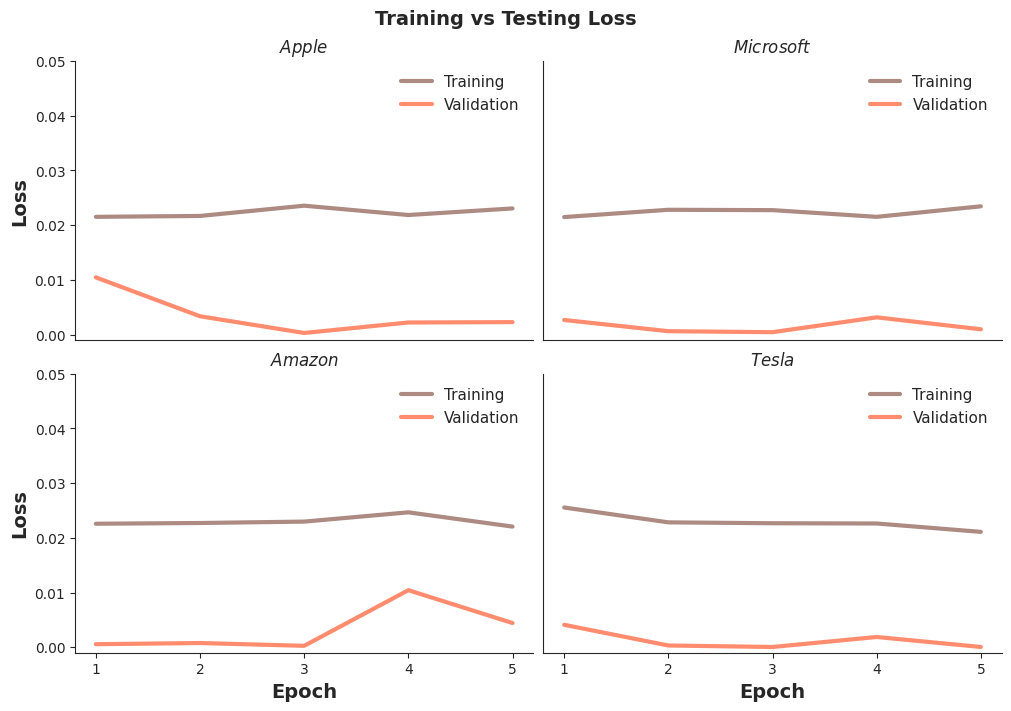

In [ ]:
fig, ax = plt.subplots(2,2, layout='constrained', figsize=(10,7))

x = [0,1,2,3,4,5]
train_col = '#AD8B82'
val_col = '#FF8C6E'

sns.set_style("ticks")
a = sns.lineplot(aapl_fit.history['loss'], color=train_col, label='Training', linewidth=3, ax=ax[0, 0])
b = sns.lineplot(aapl_fit.history['val_loss'], color=val_col, label='Validation', legend=True, linewidth=3, ax=ax[0, 0])
b.set_ylabel("Loss", fontsize=14, fontweight="bold")
b.legend(fontsize=11, loc='upper right', edgecolor='white')
b.xaxis.set_major_locator(mticker.MultipleLocator(1))
b.set_ylim(-0.001, .05)
b.set_xticklabels(x)
b.get_xaxis().set_visible(False)

c = sns.lineplot(amzn_fit.history['loss'], color=train_col, label='Training', linewidth=3, ax=ax[1, 0])
d = sns.lineplot(amzn_fit.history['val_loss'], color=val_col, label='Validation', legend=True, linewidth=3, ax=ax[1, 0])
d.set_ylabel("Loss", fontsize=14, fontweight="bold")
d.set_xlabel("Epoch", fontsize=14, fontweight="bold")
d.legend(fontsize=11, loc='upper right', edgecolor='white')
d.xaxis.set_major_locator(mticker.MultipleLocator(1))
d.set_ylim(-0.001, .05)
d.set_xticklabels(x)

e = sns.lineplot(msft_fit.history['loss'], color=train_col, label='Training', linewidth=3, ax=ax[0, 1])
f = sns.lineplot(msft_fit.history['val_loss'], color=val_col, label='Validation', legend=True, linewidth=3, ax=ax[0, 1])
f.legend(fontsize=11, loc='upper right', edgecolor='white')
f.xaxis.set_major_locator(mticker.MultipleLocator(1))
f.set_xticklabels(x)
f.set_ylim(-0.001, .05)
f.get_yaxis().set_visible(False)
f.get_xaxis().set_visible(False)

g = sns.lineplot(tsla_fit.history['loss'], color=train_col, label='Training', linewidth=3, ax=ax[1, 1])
h = sns.lineplot(tsla_fit.history['val_loss'], color=val_col, label='Validation', legend=True, linewidth=3, ax=ax[1, 1])
h.set_xlabel("Epoch", fontsize=14, fontweight="bold")
h.legend(fontsize=11, loc='upper right', edgecolor='white')
h.xaxis.set_major_locator(mticker.MultipleLocator(1))
h.set_xticklabels(x)
h.set_ylim(-0.001, .05)
h.get_yaxis().set_visible(False)

ax[0, 0].set_title("$\it{Apple}$")
ax[1, 0].set_title("$\it{Amazon}$")
ax[0, 1].set_title("$\it{Microsoft}$")
ax[1, 1].set_title("$\it{Tesla}$")
fig.suptitle("Training vs Testing Loss", fontsize=14, fontweight='bold')
plt.subplots_adjust(bottom=100)
sns.despine()

plt.show

In [22]:
# dataset to test(ej): aapl_testX, aapl_testY, amzn_testX, amzn_testY, msft_testX, msft_testY, tsla_testX, tsla_testY

aapl_yhat_s = aapl_model.predict(aapl_testX)
amzn_yhat_s = amzn_model.predict(amzn_testX)
msft_yhat_s = msft_model.predict(msft_testX)
tsla_yhat_s = tsla_model.predict(tsla_testX)

4/4 [==============================] - 0s 5ms/step


In [23]:
aapl_yhat = [x for i in aapl_yhat_s for x in i]
amzn_yhat = [x for i in amzn_yhat_s for x in i]
msft_yhat = [x for i in msft_yhat_s for x in i]
tsla_yhat = [x for i in tsla_yhat_s for x in i]

In [24]:
aapl_testY_c = [x for i in aapl_testY for x in i]
amzn_testY_c = [x for i in amzn_testY for x in i]
msft_testY_c = [x for i in msft_testY for x in i]
tsla_testY_c = [x for i in tsla_testY for x in i]

<ipython-input-25-045279ac6993>:38: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=100)


<function matplotlib.pyplot.show(close=None, block=None)>

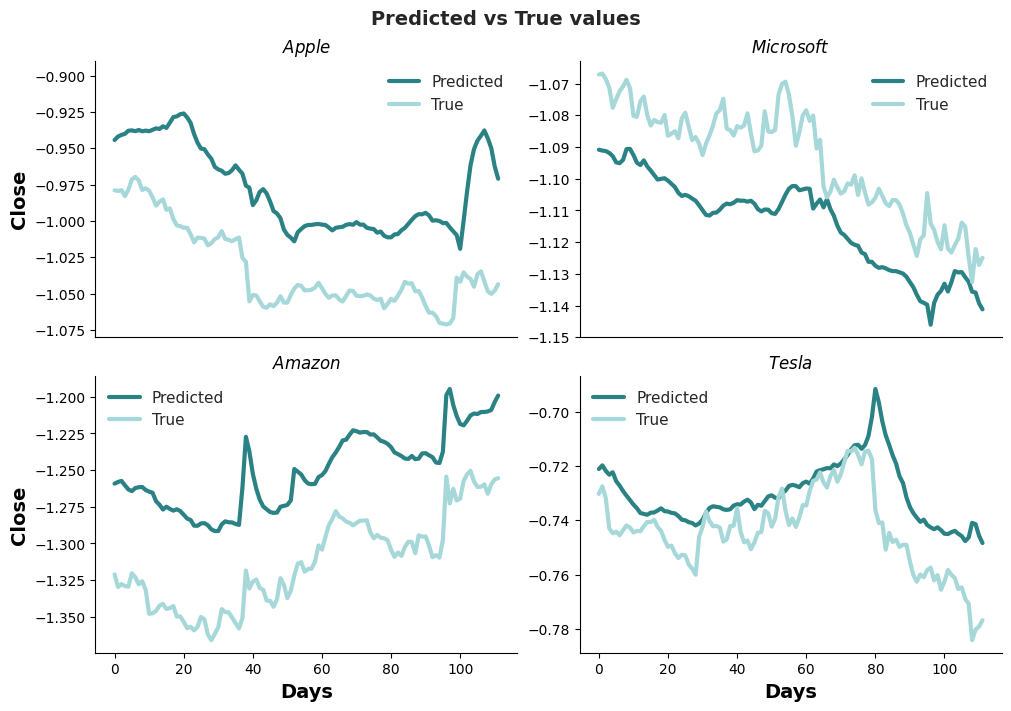

In [25]:
plt.rcdefaults()
fig, ax = plt.subplots(2,2, layout='constrained', figsize=(10,7))

x = [0,1,2,3,4,5]
train_col = '#2A8285'
val_col = '#A6D8DA'

sns.set_style("ticks")
a = sns.lineplot(aapl_yhat, color=train_col, label='Predicted', linewidth=3, ax=ax[0, 0])
b = sns.lineplot(aapl_testY_c, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[0, 0])
b.set_ylabel("Close", fontsize=14, fontweight="bold")
b.legend(fontsize=11, loc='upper right', edgecolor='white')
b.get_xaxis().set_visible(False)
b.set_ylim(-1.08, -.89)

c = sns.lineplot(amzn_yhat, color=train_col, label='Predicted', linewidth=3, ax=ax[1, 0])
d = sns.lineplot(amzn_testY_c, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[1, 0])
d.set_ylabel("Close", fontsize=14, fontweight="bold")
d.set_xlabel("Days", fontsize=14, fontweight="bold")
d.legend(fontsize=11, loc='upper left', edgecolor='white')

e = sns.lineplot(msft_yhat, color=train_col, label='Predicted', linewidth=3, ax=ax[0, 1])
f = sns.lineplot(msft_testY_c, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[0, 1])
f.legend(fontsize=11, loc='upper right', edgecolor='white')
#f.set_ylim(-1.33, -1)
f.get_xaxis().set_visible(False)

g = sns.lineplot(tsla_yhat, color=train_col, label='Predicted', linewidth=3, ax=ax[1, 1])
h = sns.lineplot(tsla_testY_c, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[1, 1])
h.set_xlabel("Days", fontsize=14, fontweight="bold")
h.legend(fontsize=11, loc='upper left', edgecolor='white')

ax[0, 0].set_title("$\it{Apple}$")
ax[1, 0].set_title("$\it{Amazon}$")
ax[0, 1].set_title("$\it{Microsoft}$")
ax[1, 1].set_title("$\it{Tesla}$")
fig.suptitle("Predicted vs True values", fontsize=14, fontweight='bold')
plt.subplots_adjust(bottom=100)
sns.despine()

plt.show

In [26]:
# Function to get the inverse scaler transformation made before the fitting
def inverse_tr(arr, shape, scal, axis=-1):
  copies = np.repeat(arr, shape, axis)
  inverse_num = scal.inverse_transform(copies)[:,0]
  return inverse_num

In [27]:
aapl_y_hat_inv = inverse_tr(aapl_yhat_s, aapl_ds_ws.shape[1], aapl_scal)
amzn_y_hat_inv = inverse_tr(amzn_yhat_s, amzn_ds_ws.shape[1], amzn_scal)
msft_y_hat_inv = inverse_tr(msft_yhat_s, msft_ds_ws.shape[1], msft_scal)
tsla_y_hat_inv = inverse_tr(tsla_yhat_s, tsla_ds_ws.shape[1], tsla_scal)

In [28]:
aapl_y_inv = inverse_tr(aapl_testY, aapl_ds_ws.shape[1], aapl_scal)
amzn_y_inv = inverse_tr(amzn_testY, amzn_ds_ws.shape[1], amzn_scal)
msft_y_inv = inverse_tr(msft_testY, msft_ds_ws.shape[1], msft_scal)
tsla_y_inv = inverse_tr(tsla_testY, tsla_ds_ws.shape[1], tsla_scal)

<ipython-input-29-12d54c56504b>:50: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=100)


<function matplotlib.pyplot.show(close=None, block=None)>

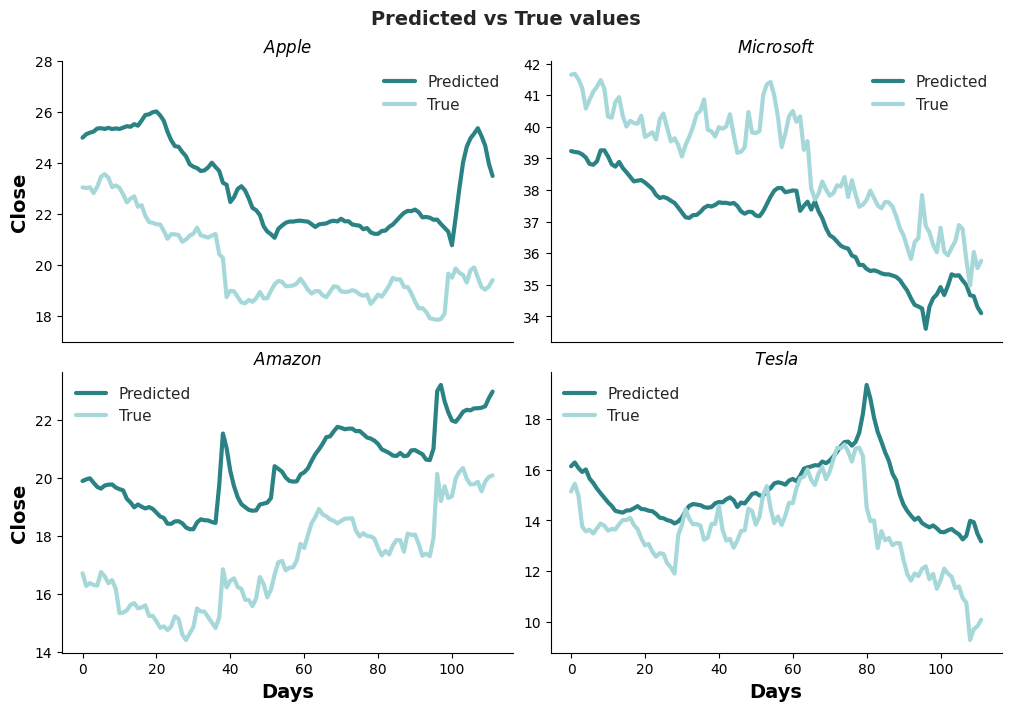

In [29]:
plt.rcdefaults()
fig, ax = plt.subplots(2,2, layout='constrained', figsize=(10,7))

x = [0,1,2,3,4,5]
train_col = '#2A8285'
val_col = '#A6D8DA'

sns.set_style("ticks")
a = sns.lineplot(aapl_y_hat_inv, color=train_col, label='Predicted', linewidth=3, ax=ax[0, 0])
b = sns.lineplot(aapl_y_inv, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[0, 0])
b.set_ylabel("Close", fontsize=14, fontweight="bold")
b.legend(fontsize=11, loc='upper right', edgecolor='white')
b.get_xaxis().set_visible(False)
#b.xaxis.set_major_locator(mticker.MultipleLocator(1))
b.set_ylim(17, 28)
#b.set_xticklabels(x)

c = sns.lineplot(amzn_y_hat_inv, color=train_col, label='Predicted', linewidth=3, ax=ax[1, 0])
d = sns.lineplot(amzn_y_inv, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[1, 0])
d.set_ylabel("Close", fontsize=14, fontweight="bold")
d.set_xlabel("Days", fontsize=14, fontweight="bold")
d.legend(fontsize=11, loc='upper left', edgecolor='white')
#d.xaxis.set_major_locator(mticker.MultipleLocator(1))
#d.set_ylim(-0.01, .20)
#d.set_xticklabels(x)

e = sns.lineplot(msft_y_hat_inv, color=train_col, label='Predicted', linewidth=3, ax=ax[0, 1])
f = sns.lineplot(msft_y_inv, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[0, 1])
f.legend(fontsize=11, loc='upper right', edgecolor='white')
#f.xaxis.set_major_locator(mticker.MultipleLocator(1))
#f.set_xticklabels(x)
#f.set_ylim(-1.33, -1)
#f.get_yaxis().set_visible(False)
f.get_xaxis().set_visible(False)

g = sns.lineplot(tsla_y_hat_inv, color=train_col, label='Predicted', linewidth=3, ax=ax[1, 1])
h = sns.lineplot(tsla_y_inv, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[1, 1])
h.set_xlabel("Days", fontsize=14, fontweight="bold")
h.legend(fontsize=11, loc='upper left', edgecolor='white')
#h.xaxis.set_major_locator(mticker.MultipleLocator(1))
#h.set_xticklabels(x)
#h.set_ylim(-0.01, .20)
#h.get_yaxis().set_visible(False)

ax[0, 0].set_title("$\it{Apple}$")
ax[1, 0].set_title("$\it{Amazon}$")
ax[0, 1].set_title("$\it{Microsoft}$")
ax[1, 1].set_title("$\it{Tesla}$")
fig.suptitle("Predicted vs True values", fontsize=14, fontweight='bold')
plt.subplots_adjust(bottom=100)
sns.despine()

plt.show

In [30]:
# Calculating SE, MSE, RMSE, and MAPE  to compare the performance of both models
def metrics_model(predicted, real, model_name):
  predicted = np.asanyarray(predicted)
  real = np.asanyarray(real)
  se = np.square(predicted - real)
  mse = np.mean(se).round(1)
  rmse = np.sqrt(mse).round(1)
  mape = np.mean(np.abs(real - predicted)/np.abs(real)).round(2)

  results = {'Company': model_name,
      'MSE':mse,
      'RMSE':rmse,
      'MAPE':'{:.0%}'.format(mape)
             }
  return results

def table_metrics(metrics1, metrics2, metrics3, metrics4):
  return pd.DataFrame([metrics1, metrics2, metrics3, metrics4])


In [31]:
Apple_metrics = metrics_model(aapl_y_hat_inv, aapl_y_inv, 'Apple')
Amazon_metrics = metrics_model(amzn_y_hat_inv, amzn_y_inv, 'Amazon')
Microsoft_metrics = metrics_model(msft_y_hat_inv, msft_y_inv, 'Microsoft')
Tesla_metrics = metrics_model(tsla_y_hat_inv, tsla_y_inv, 'Tesla')

table_metrics(Apple_metrics, Amazon_metrics, Microsoft_metrics, Tesla_metrics)

,Company,MSE,RMSE,MAPE
0,Apple,10.5,3.2,16%
1,Amazon,10.5,3.2,19%
2,Microsoft,4.5,2.1,5%
3,Tesla,3.3,1.8,11%


<ipython-input-32-d1fecba5fc1a>:54: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=100)


<function matplotlib.pyplot.show(close=None, block=None)>

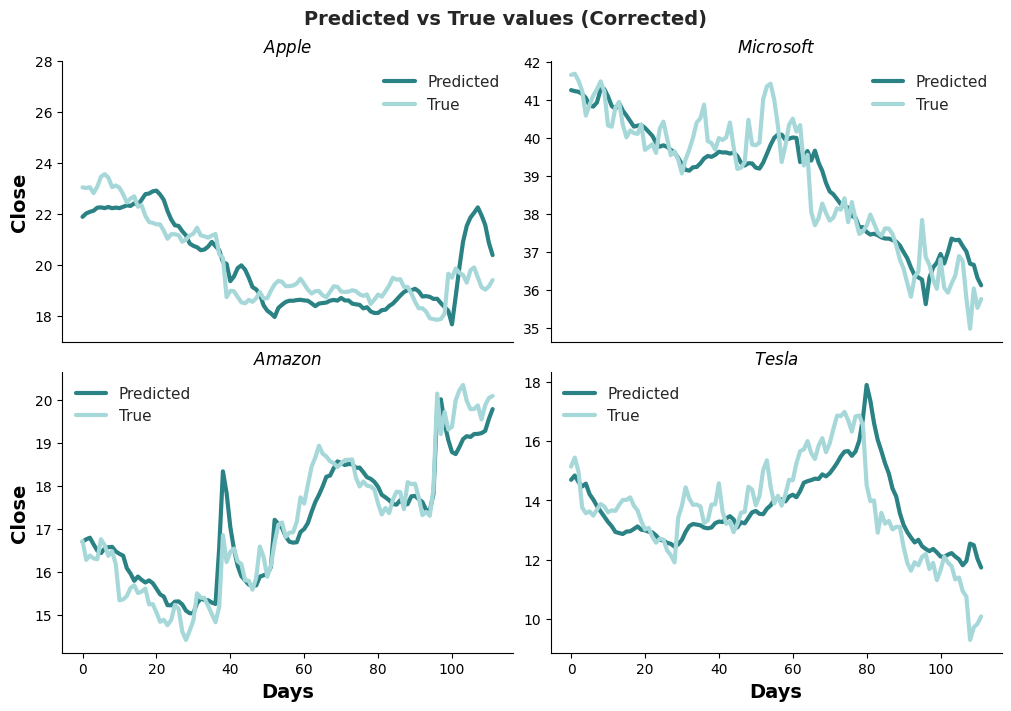

In [32]:
plt.rcdefaults()
fig, ax = plt.subplots(2,2, layout='constrained', figsize=(10,7))

x = [0,1,2,3,4,5]
train_col = '#2A8285'
val_col = '#A6D8DA'
aapl_yhat_mod=aapl_y_hat_inv-np.mean(np.subtract(aapl_y_hat_inv ,aapl_y_inv))
amzn_yhat_mod=amzn_y_hat_inv-np.mean(np.subtract(amzn_y_hat_inv ,amzn_y_inv))
msft_yhat_mod=msft_y_hat_inv-np.mean(np.subtract(msft_y_hat_inv ,msft_y_inv))
tsla_yhat_mod=tsla_y_hat_inv-np.mean(np.subtract(tsla_y_hat_inv ,tsla_y_inv))
sns.set_style("ticks")

a = sns.lineplot(aapl_yhat_mod, color=train_col, label='Predicted', linewidth=3, ax=ax[0, 0])
b = sns.lineplot(aapl_y_inv, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[0, 0])
b.set_ylabel("Close", fontsize=14, fontweight="bold")
b.legend(fontsize=11, loc='upper right', edgecolor='white')
b.get_xaxis().set_visible(False)
#b.xaxis.set_major_locator(mticker.MultipleLocator(1))
b.set_ylim(17, 28)
#b.set_xticklabels(x)

c = sns.lineplot(amzn_yhat_mod, color=train_col, label='Predicted', linewidth=3, ax=ax[1, 0])
d = sns.lineplot(amzn_y_inv, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[1, 0])
d.set_ylabel("Close", fontsize=14, fontweight="bold")
d.set_xlabel("Days", fontsize=14, fontweight="bold")
d.legend(fontsize=11, loc='upper left', edgecolor='white')
#d.xaxis.set_major_locator(mticker.MultipleLocator(1))
#d.set_ylim(-0.01, .20)
#d.set_xticklabels(x)

e = sns.lineplot(msft_yhat_mod, color=train_col, label='Predicted', linewidth=3, ax=ax[0, 1])
f = sns.lineplot(msft_y_inv, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[0, 1])
f.legend(fontsize=11, loc='upper right', edgecolor='white')
#f.xaxis.set_major_locator(mticker.MultipleLocator(1))
#f.set_xticklabels(x)
#f.set_ylim(-1.33, -1)
#f.get_yaxis().set_visible(False)
f.get_xaxis().set_visible(False)

g = sns.lineplot(tsla_yhat_mod, color=train_col, label='Predicted', linewidth=3, ax=ax[1, 1])
h = sns.lineplot(tsla_y_inv, color=val_col, label='True', legend='auto', linewidth=3, ax=ax[1, 1])
h.set_xlabel("Days", fontsize=14, fontweight="bold")
h.legend(fontsize=11, loc='upper left', edgecolor='white')
#h.xaxis.set_major_locator(mticker.MultipleLocator(1))
#h.set_xticklabels(x)
#h.set_ylim(-0.01, .20)
#h.get_yaxis().set_visible(False)

ax[0, 0].set_title("$\it{Apple}$")
ax[1, 0].set_title("$\it{Amazon}$")
ax[0, 1].set_title("$\it{Microsoft}$")
ax[1, 1].set_title("$\it{Tesla}$")
fig.suptitle("Predicted vs True values (Corrected)", fontsize=14, fontweight='bold')
plt.subplots_adjust(bottom=100)
sns.despine()

plt.show

# Save and Load the trained model

In [20]:
from tensorflow.keras.models import load_model
import os

In [ ]:
#aapl_model.save(os.path.join('model_trained', 'best_aapl_model.h5'))
#amzn_model.save(os.path.join('model_trained', 'best_amzn_model.h5'))
#msft_model.save(os.path.join('model_trained', 'best_msft_model.h5'))
#tsla_model.save(os.path.join('model_trained', 'best_tsla_model.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
aapl_model = load_model(os.path.join('model_trained', 'best_aapl_model.h5'))
amzn_model = load_model(os.path.join('model_trained', 'best_amzn_model.h5'))
msft_model = load_model(os.path.join('model_trained', 'best_msft_model.h5'))
tsla_model = load_model(os.path.join('model_trained', 'best_tsla_model.h5'))